In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.tree import DecisionTreeClassifier
import re


In [2]:
file_path = "/Users/janybalashiva/Downloads/Loan Eligibility Prediction.csv"
df = pd.read_csv(file_path)
print(df.head())

   Customer_ID  Gender Married  Dependents     Education Self_Employed  \
0          569  Female      No           0      Graduate            No   
1           15    Male     Yes           2      Graduate            No   
2           95    Male      No           0  Not Graduate            No   
3          134    Male     Yes           0      Graduate           Yes   
4          556    Male     Yes           1      Graduate            No   

   Applicant_Income  Coapplicant_Income  Loan_Amount  Loan_Amount_Term  \
0              2378                 0.0            9               360   
1              1299              1086.0           17               120   
2              3620                 0.0           25               120   
3              3459                 0.0           25               120   
4              5468              1032.0           26               360   

   Credit_History Property_Area Loan_Status  
0               1         Urban           N  
1               1 

In [3]:
df.rename(columns={"Loan_Status ": "Loan_Status"}, inplace=True)


In [4]:
print(df["Loan_Status"].value_counts())

Loan_Status
Y    422
N    192
Name: count, dtype: int64


In [5]:
cat_features = df.select_dtypes(include='object')
print(cat_features.head())

   Gender Married     Education Self_Employed Property_Area Loan_Status
0  Female      No      Graduate            No         Urban           N
1    Male     Yes      Graduate            No         Urban           Y
2    Male      No  Not Graduate            No     Semiurban           Y
3    Male     Yes      Graduate           Yes     Semiurban           Y
4    Male     Yes      Graduate            No     Semiurban           Y


In [6]:
le = LabelEncoder()
encoded_num_df = pd.DataFrame()
for col in cat_features.columns:
    encoded_num_df[col] = le.fit_transform(cat_features[col])

print(encoded_num_df.head())

   Gender  Married  Education  Self_Employed  Property_Area  Loan_Status
0       0        0          0              0              2            0
1       1        1          0              0              2            1
2       1        0          1              0              1            1
3       1        1          0              1              1            1
4       1        1          0              0              1            1


In [7]:
df = df.drop(cat_features.columns, axis=1)
df = pd.concat([df, encoded_num_df], axis=1)


In [8]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('Loan_Status', axis=1), df['Loan_Status'], test_size=0.2, random_state=42)

In [9]:
sc = MinMaxScaler()
sc_x_train = pd.DataFrame(sc.fit_transform(x_train), columns=sc.feature_names_in_)
sc_x_test = pd.DataFrame(sc.transform(x_test), columns=sc.feature_names_in_)


In [10]:
mutual_info_scores = mutual_info_classif(sc_x_train, y_train)
feature_scores_df = pd.DataFrame({'Feature': sc_x_train.columns, 'Mutual_Info_Score': mutual_info_scores})
feature_scores_df = feature_scores_df.sort_values(by='Mutual_Info_Score', ascending=False)


In [11]:
selected_features = feature_scores_df.head(15)['Feature'].tolist()
print("Selected Features:", selected_features)


Selected Features: ['Credit_History', 'Gender', 'Self_Employed', 'Property_Area', 'Customer_ID', 'Dependents', 'Coapplicant_Income', 'Education', 'Married', 'Applicant_Income', 'Loan_Amount', 'Loan_Amount_Term']


In [12]:
feature_selection_train = sc_x_train[selected_features]
feature_selection_test = sc_x_test[selected_features]


In [14]:
logreg = LogisticRegression(max_iter=200)  # Corrected the typo here
logreg.fit(feature_selection_train, y_train)
y_pred = logreg.predict(feature_selection_test)


In [15]:
logrepo = classification_report(y_test, y_pred)
print(logrepo)

              precision    recall  f1-score   support

           0       0.95      0.47      0.63        40
           1       0.80      0.99      0.88        83

    accuracy                           0.82       123
   macro avg       0.87      0.73      0.76       123
weighted avg       0.85      0.82      0.80       123



In [16]:
y_pred_proba_log = logreg.predict_proba(feature_selection_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_log)
roc_auc = auc(fpr, tpr)


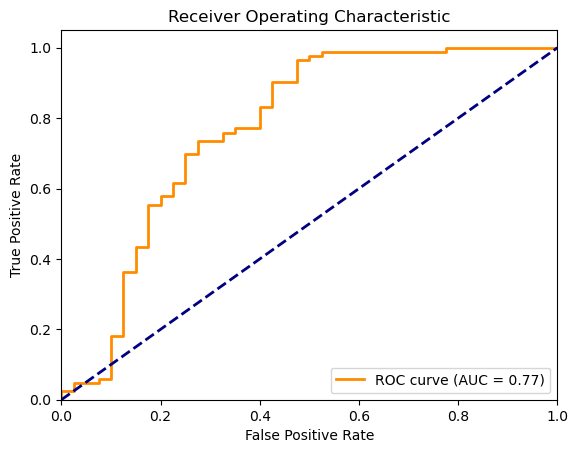

In [17]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

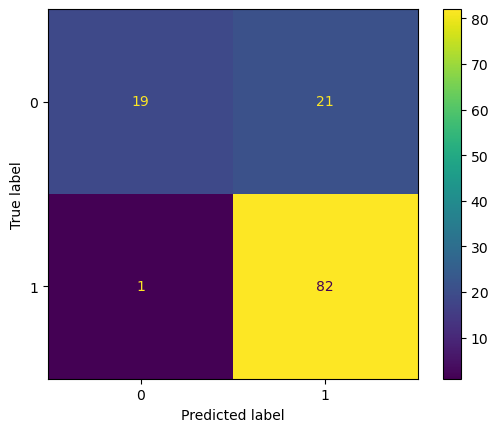

In [18]:
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.show()

In [19]:
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(feature_selection_train, y_train)
y_pred_dt = dt_classifier.predict(feature_selection_test)


In [20]:
dtree = classification_report(y_test, y_pred_dt)
print(dtree)

              precision    recall  f1-score   support

           0       0.62      0.65      0.63        40
           1       0.83      0.81      0.82        83

    accuracy                           0.76       123
   macro avg       0.72      0.73      0.73       123
weighted avg       0.76      0.76      0.76       123



In [21]:
y_pred_proba = dt_classifier.predict_proba(feature_selection_test)[:, 1]
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_pred_proba)
roc_auc_dt = auc(fpr_dt, tpr_dt)

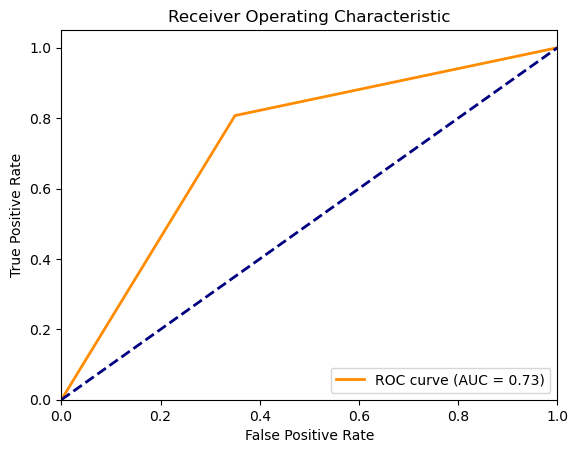

In [22]:
plt.figure()
plt.plot(fpr_dt, tpr_dt, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_dt)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

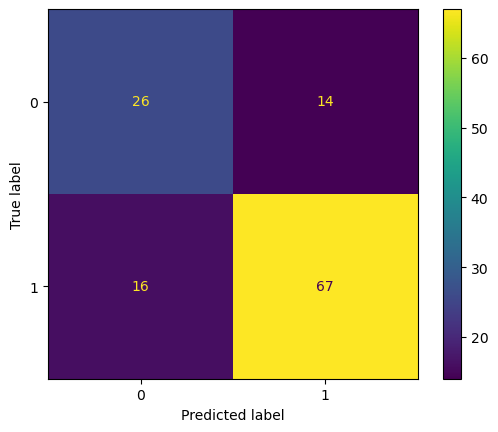

In [23]:
conf_matrix2 = confusion_matrix(y_test, y_pred_dt)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix2)
disp.plot()
plt.show()

In [24]:
def parse_classification_report(report):
    lines = report.split('\n')
    parsed_data = []
    for line in lines[2:-3]:
        line_data = re.split(r'\s{2,}', line.strip())
        if len(line_data) < 5:
            continue
        class_name = line_data[0]
        precision = float(line_data[1])
        recall = float(line_data[2])
        f1_score = float(line_data[3])
        support = float(line_data[4])
        parsed_data.append({
            'class': class_name,
            'precision': precision,
            'recall': recall,
            'f1-score': f1_score,
            'support': support
        })
    df = pd.DataFrame(parsed_data)
    return df

df1 = parse_classification_report(dtree)
df2 = parse_classification_report(logrepo)


In [25]:
df1['model'] = 'Decision Tree'
df2['model'] = 'Logistic Regression'


In [26]:
comparison_df = pd.concat([df1, df2])

In [27]:
comparison_df = comparison_df[['model', 'class', 'precision', 'recall', 'f1-score', 'support']]


In [28]:
import ace_tools as tools; tools.display_dataframe_to_user(name="Model Comparison Table", dataframe=comparison_df)

comparison_df

ModuleNotFoundError: No module named 'ace_tools'